In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

##### Load files from monthly averages

In [3]:
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['microzooplankton']


# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in tqdm(years):
    
    # Initialize lists
    for var in variables: data[var] = []
    
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            for var in ['microzooplankton']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
   
# Calculate climatological mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

In [4]:
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var2].isel(z=slice(None, 27),**slc).values for var2 in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['microzooplankton']


# Temporary list dict
data2 = {}

# Permanent aggregate dict
aggregates2 = {var2: {} for var2 in variables}

# Loop through years
for year in tqdm(years):
    
    # Initialize lists
    for var2 in variables: data2[var2] = []
    
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            for var2 in ['microzooplankton']:
                data2[var2].append(np.ma.masked_where(tmask == 0, ds[var2].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    
    # Concatenate months
    for var2 in variables: aggregates2[var2][year] = np.concatenate(data2[var2]).mean(axis=0)
   
# Calculate climatological mean and anomalies
for var in variables:
    aggregates2[var2]['mean'] = np.concatenate([aggregates2[var2][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates2[var2][year] = aggregates2[var2][year] - aggregates2[var2]['mean']

In [5]:
print(np.shape(aggregates['microzooplankton'][2007][:]))

(898, 398)


In [6]:
# Reset variables for plotting
tmask = tmask[0, 0, ...]
variables = ['microzooplankton']

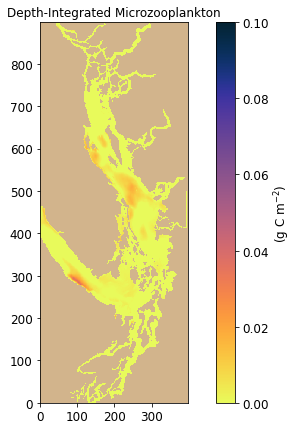

In [7]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=0
vmax=.1
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=100

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,((((aggregates['microzooplankton']['mean'])-(aggregates2['microzooplankton']['mean']))*5.7*12/1000))),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Depth-Integrated Microzooplankton')
#ax.yaxis.set_visible(False)
#ax.xaxis.set_visible(False)
fig.colorbar(m0,ax=ax,label='(g C m$^{-2}$)')

In [8]:
np.nanmax(aggregates['microzooplankton']['mean'])

25.920685812235156

In [9]:
np.nanmax(aggregates2['microzooplankton']['mean'])

26.01495512124268

In [10]:
np.nanmin(aggregates['microzooplankton']['mean'])

0.0

In [11]:
np.nanmean(aggregates['microzooplankton']['mean'])

2.5203835330092272

In [12]:
np.nanmean(aggregates2['microzooplankton']['mean'])

2.5450505143216935

In [13]:
np.nanmax(aggregates['microzooplankton']['mean']*5.7*12/1000)

1.772974909556885

In [14]:
np.nanmin(aggregates['microzooplankton']['mean']*5.7*12/1000)

0.0

In [15]:
np.nanmean(aggregates['microzooplankton']['mean']*5.7*12/1000)

0.17239423365783116

In [16]:
np.nanmean(aggregates2['microzooplankton']['mean']*5.7*12/1000)

0.17408145517960388

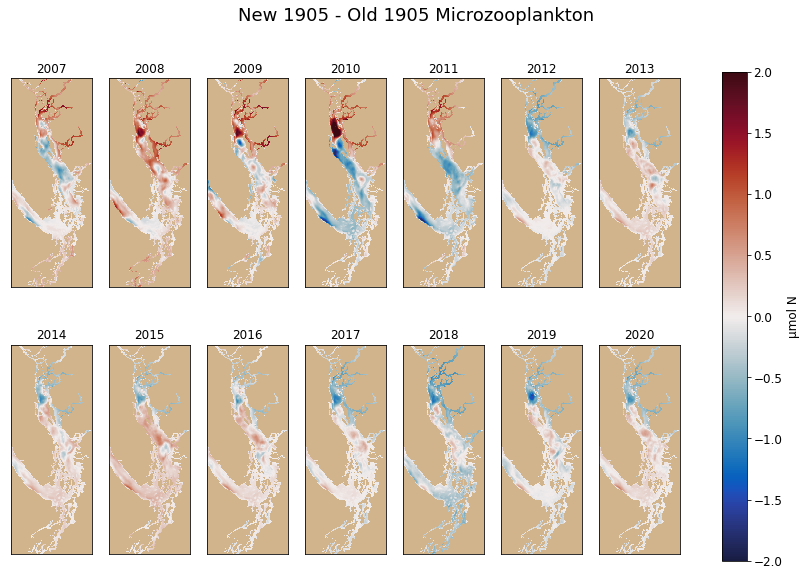

In [18]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')

#cmap1=cmocean.cm.haline
#cmap1.set_bad('k')
il=0
vmin=-2
vmax=2

fig,ax=plt.subplots(2,7,figsize=(15,9))
fig.suptitle('New 1905 - Old 1905 Microzooplankton', fontsize=18)


m0=ax[0,0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2007])-(aggregates['microzooplankton'][2007]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,0],coords='grid')
ax[0,0].set_title('2007')
ax[0,0].yaxis.set_visible(False)
ax[0,0].xaxis.set_visible(False)
ax[0,0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[0,1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2008])-(aggregates['microzooplankton'][2008]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,1],coords='grid')
ax[0,1].set_title('2008')
ax[0,1].yaxis.set_visible(False)
ax[0,1].xaxis.set_visible(False)
ax[0,1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[0,2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2009])-(aggregates['microzooplankton'][2009]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,2],coords='grid')
ax[0,2].set_title('2009')
ax[0,2].yaxis.set_visible(False)
ax[0,2].xaxis.set_visible(False)
ax[0,2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[0,3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2010])-(aggregates['microzooplankton'][2010]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,3],coords='grid')
ax[0,3].set_title('2010')
ax[0,3].yaxis.set_visible(False)
ax[0,3].xaxis.set_visible(False)
ax[0,3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[0,4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2011])-(aggregates['microzooplankton'][2011]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,4],coords='grid')
ax[0,4].set_title('2011')
ax[0,4].yaxis.set_visible(False)
ax[0,4].xaxis.set_visible(False)
ax[0,4].yaxis.set_visible(False)

m0=ax[0,5].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2012])-(aggregates['microzooplankton'][2012]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,5],coords='grid')
ax[0,5].set_title('2012')
ax[0,5].yaxis.set_visible(False)
ax[0,5].xaxis.set_visible(False)
ax[0,5].yaxis.set_visible(False)

m0=ax[0,6].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2013])-(aggregates['microzooplankton'][2013]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,6],coords='grid')
ax[0,6].set_title('2013')
ax[0,6].yaxis.set_visible(False)
ax[0,6].xaxis.set_visible(False)
ax[0,6].yaxis.set_visible(False)

m0=ax[1,0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2014])-(aggregates['microzooplankton'][2014]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,0],coords='grid')
ax[1,0].set_title('2014')
ax[1,0].yaxis.set_visible(False)
ax[1,0].xaxis.set_visible(False)
ax[1,0].yaxis.set_visible(False)

m0=ax[1,1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2015])-(aggregates['microzooplankton'][2015]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,1],coords='grid')
ax[1,1].set_title('2015')
ax[1,1].yaxis.set_visible(False)
ax[1,1].xaxis.set_visible(False)
ax[1,1].yaxis.set_visible(False)

m0=ax[1,2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2016])-(aggregates['microzooplankton'][2016]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,2],coords='grid')
ax[1,2].set_title('2016')
ax[1,2].yaxis.set_visible(False)
ax[1,2].xaxis.set_visible(False)
ax[1,2].yaxis.set_visible(False)

m0=ax[1,3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2017])-(aggregates['microzooplankton'][2017]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,3],coords='grid')
ax[1,3].set_title('2017')
ax[1,3].yaxis.set_visible(False)
ax[1,3].xaxis.set_visible(False)
ax[1,3].yaxis.set_visible(False)

m0=ax[1,4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2018])-(aggregates['microzooplankton'][2018]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,4],coords='grid')
ax[1,4].set_title('2018')
ax[1,4].yaxis.set_visible(False)
ax[1,4].xaxis.set_visible(False)
ax[1,4].yaxis.set_visible(False)

m0=ax[1,5].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2019])-(aggregates['microzooplankton'][2019]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,5],coords='grid')
ax[1,5].set_title('2019')
ax[1,5].yaxis.set_visible(False)
ax[1,5].xaxis.set_visible(False)
ax[1,5].yaxis.set_visible(False)

m0=ax[1,6].pcolormesh(np.ma.masked_where(tmask==0,((aggregates2['microzooplankton'][2020])-(aggregates['microzooplankton'][2020]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,6],coords='grid')
ax[1,6].set_title('2020')
ax[1,6].yaxis.set_visible(False)
ax[1,6].xaxis.set_visible(False)
ax[1,6].yaxis.set_visible(False)

fig.colorbar(m0,ax=ax,label='\u03bcmol N')


##### mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
dept=np.copy(mask.variables['gdept_1d'])
jpk75=0
for i in range(0,40): #stays same b/c grid cells or write len(dept[0]) instead of 40
    if dept[0][i]<=100:#change this to get diff depths in water column
        jpk75=i
print(jpk75)
jpk75=jpk75+1
print(jpk75)